# Purpose

Compare the learnability of GO terms from composition-induced co-expression across manually curated tissue categories to their MGC Scores

In [101]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import os
import statsmodels.formula.api as smf


### Load GO Performance from composition-induced co-expression

In [102]:
def load_learnability(path:str)->pd.DataFrame:
	"""Load a dataframe containing info about a GO term's learnability from composition-induced co-expression

	Args:
		path (str): file path

	Returns:
		pd.DataFrame: df
	"""
	GO_learnabilty_df = pd.read_csv(path,index_col=0)

	# extract and drop some metadata columns
	GO_learnabilty_df['exp_type'] = GO_learnabilty_df.organism_part.str.split("_").str.get(0)
	GO_learnabilty_df['tissue'] = GO_learnabilty_df.organism_part.str.split("_").str.get(1)
	GO_learnabilty_df = GO_learnabilty_df[GO_learnabilty_df.loc[:,'variance']==0.05]
	GO_learnabilty_df.drop('organism_part', axis =1 , inplace=True)
	GO_learnabilty_df.drop('variance', axis =1 , inplace=True)

	return GO_learnabilty_df
	
path_to_learnability_file = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_run_feb29/master_melted_df.csv.gz"
GO_learnabilty_df = load_learnability(path_to_learnability_file)
GO_learnabilty_df.head()

,index,bootstrap,auc,exp_type,tissue
1397,GO:0000045,3,0.522443,cntrl,brain
1398,GO:0000070,3,0.504677,cntrl,brain
1399,GO:0000077,3,0.468358,cntrl,brain
1400,GO:0000079,3,0.498369,cntrl,brain
1401,GO:0000082,3,0.520443,cntrl,brain


# Load MGES scores

In [103]:
def load_mges_scores(mges_path:str, mgesname:str)->pd.DataFrame:
	"""Load MGES dictionary

	Args:
		mges_path (str): path to dict
		mgesname (str): name of MGES type (Brain or PBMC)

	Returns:
		pd.DataFrame: has GO term and term's MGES score
	"""
	# Load the JSON file into a dictionary
	with open(mges_path, 'r') as json_file:
		mges = json.load(json_file)
	
	# Convert the dictionary to a DataFrame
	mges = pd.DataFrame(list(mges.items()), columns=['GO', mgesname])
	
	return mges

brain_mges = load_mges_scores("../MGES/data/brain_mges.json", 'brainMGES')
pbmc_mges = load_mges_scores("../MGES/data/pbmc_mges.json", 'pbmcMGES')

# Merge Learnability with GO MGES scores

In [104]:
GO_learnabilty_df = GO_learnabilty_df.merge(brain_mges, left_on='index', right_on='GO')
GO_learnabilty_df = GO_learnabilty_df.merge(pbmc_mges, on="GO")
GO_learnabilty_df.head()

,index,bootstrap,auc,exp_type,tissue,GO,brainMGES,pbmcMGES
0,GO:0000045,3,0.522443,cntrl,brain,GO:0000045,0.191122,0.373829
1,GO:0000045,3,0.537387,exp,brain,GO:0000045,0.191122,0.373829
2,GO:0000045,1,0.562481,exp,pbmc,GO:0000045,0.191122,0.373829
3,GO:0000045,2,0.589985,exp,pbmc,GO:0000045,0.191122,0.373829
4,GO:0000045,5,0.503032,cntrl,pbmc,GO:0000045,0.191122,0.373829


In [105]:
GO_learnability_melted = GO_learnabilty_df.melt(id_vars=['index','bootstrap','auc','exp_type','tissue', 'GO'], var_name='mges_type', value_name='mges')
GO_learnability_melted

,index,bootstrap,auc,exp_type,tissue,GO,mges_type,mges
0,GO:0000045,3,0.522443,cntrl,brain,GO:0000045,brainMGES,0.191122
1,GO:0000045,3,0.537387,exp,brain,GO:0000045,brainMGES,0.191122
2,GO:0000045,1,0.562481,exp,pbmc,GO:0000045,brainMGES,0.191122
3,GO:0000045,2,0.589985,exp,pbmc,GO:0000045,brainMGES,0.191122
4,GO:0000045,5,0.503032,cntrl,pbmc,GO:0000045,brainMGES,0.191122
...,...,...,...,...,...,...,...,...
1116795,GO:2001244,90,0.334668,cntrl,brain,GO:2001244,pbmcMGES,0.987267
1116796,GO:2001244,97,0.554312,cntrl,brain,GO:2001244,pbmcMGES,0.987267
1116797,GO:2001244,88,0.437136,cntrl,brain,GO:2001244,pbmcMGES,0.987267
1116798,GO:2001244,100,0.483414,cntrl,brain,GO:2001244,pbmcMGES,0.987267


# Correlate MGC score with performance

In [106]:
#  Calc mean for graphing convenience and reduce overplotting
GO_learnabilty_df_mean = GO_learnabilty_df.groupby(['index', 'exp_type', 'tissue','brainMGES','pbmcMGES'])['auc'].mean().reset_index()

In [107]:
brain = GO_learnabilty_df_mean[GO_learnabilty_df_mean.loc[:,'tissue']=='brain']
pbmc = GO_learnabilty_df_mean[GO_learnabilty_df_mean.loc[:,'tissue']=='pbmc']

In [108]:
brain.iloc[:,[3,4,5]].corr()

,brainMGES,pbmcMGES,auc
brainMGES,1.000000,0.083642,0.017829
pbmcMGES,0.083642,1.000000,-0.087294
auc,0.017829,-0.087294,1.000000


In [109]:
pbmc.iloc[:,[3,4,5]].corr()

,brainMGES,pbmcMGES,auc
brainMGES,1.000000,0.083642,-0.003342
pbmcMGES,0.083642,1.000000,0.037325
auc,-0.003342,0.037325,1.000000


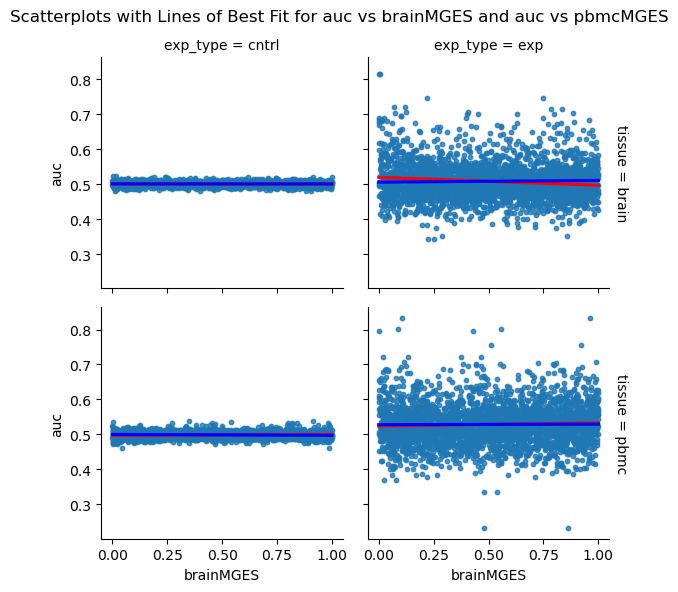

In [110]:
# def plot(GO_learnabilty_df_mean):
# 	# Assuming brain_master is your DataFrame
# 	# Create a seaborn FacetGrid
# 	g = sns.FacetGrid(aggregated_df, row='tissue', col='exp_type', margin_titles=True)

# 	# Map the scatterplot with line of best fit for 'auc' vs 'pbmcMGES'
# 	g.map(sns.regplot, 'pbmcMGES', 'auc', scatter_kws={'s':10}, line_kws={'color':'red'}, ci=None)
# 	# Map the scatterplot with line of best fit for 'auc' vs 'brainMGES'
# 	g.map(sns.regplot, 'brainMGES', 'auc', scatter_kws={'s':10}, line_kws={'color':'blue'}, ci=None)
	
# 	# Add legends and adjust the plot
# 	g.add_legend()
# 	plt.subplots_adjust(top=0.9)
# 	g.fig.suptitle('Scatterplots with Lines of Best Fit for auc vs brainMGES and auc vs pbmcMGES')

# 	# Show the plot
# 	plt.show()

# plot(GO_learnabilty_df_mean)